# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109B Introduction to Data Science
## Lab 5: Convolutional Neural Networks

**Harvard University**<br>
**Spring 2019**<br>
**Lab instructor:** Eleni Kaxiras<br>
**Instructors:** Pavlos Protopapas and Mark Glickman<br>
**Authors:** Eleni Kaxiras, Pavlos Protopapas, Patrick Ohiomoba, and Davis Sontag

In [2]:
# RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals

In this lab we will look at Convolutional Neural Networks (CNNs), and their building blocks.

By the end of this lab, you should:

- know how to put together the building blocks used in CNNs - such as convolutional layers and pooling layers - in `keras` with an example.
- have a good undertanding on how images, a common type of data for a CNN, are represented in the computer and how to think of them as arrays of numbers. 
- be familiar with preprocessing images with `keras` and `sckit-learn`.
- use `keras-viz` to produce Saliency maps. 
- learn best practices for configuring the hyperparameters of a CNN.
- run your first CNN and see the error rate.

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)

import numpy as np
from scipy.optimize import minimize

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.utils import shuffle

print(tf.VERSION)
print(tf.keras.__version__)

%matplotlib inline

1.12.0
2.1.6-tf


Using TensorFlow backend.


## Prologue: `keras-viz` Visualization Toolkit

`keras-vis` is a high-level toolkit for visualizing and debugging your trained keras neural net models. Currently supported visualizations include:

- Activation maximization
- **Saliency maps** 
- Class activation maps

All visualizations by default support N-dimensional image inputs. i.e., it generalizes to N-dim image inputs to your model. Compatible with both theano and tensorflow backends with 'channels_first', 'channels_last' data format.

Read the documentation at https://raghakot.github.io/keras-vis.https://github.com/raghakot/keras-vis

To install use `pip install git+https://github.com/raghakot/keras-vis.git --upgrade`

## SEAS JupyterHub

[Instructions for Using SEAS JupyterHub](https://canvas.harvard.edu/courses/48088/pages/instructions-for-using-seas-jupyterhub)

SEAS and FAS are providing you with a platform in AWS to use for the class (accessible from the 'Jupyter' menu link in Canvas). These are AWS p2 instances with a GPU, 10GB of disk space, and 61 GB of RAM,  for faster training for your networks. Most of the libraries such as keras, tensorflow, pandas, etc. are pre-installed. If a library is missing you may install it via the Terminal.

**NOTE : The AWS platform is funded by SEAS and FAS for the purposes of the class. It is not running against your individual credit. You are not allowed to use it for purposes not related to this course.**

**Help us keep this service: Make sure you stop your instance as soon as you do not need it.**

![aws-dog](fig/aws-dog.jpeg)

## Part 1: Parts of a Convolutional Neural Net

There are three types of layers in a Convolutional Neural Network:

- Convolutional Layers
- Pooling Layers.
- Dropout Layers.
- Fully Connected Layers.

### a. Convolutional Layers.

Convolutional layers are comprised of **filters** and **feature maps**. The filters are essentially the **neurons** of the layer. They have the weights and produce the input for the next layer. The feature map is the output of one filter applied to the previous layer. 

The fundamental difference between a densely connected layer and a convolution layer is that dense layers learn global patterns in their input feature space (for example, for an MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns: in the case of images, patterns found in small 2D windows of the inputs called *receptive fields*. 

This key characteristic gives convnets two interesting properties:

- The patterns they learn are **translation invariant**. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected network would have to learn the pattern anew if it appeared at a new location. This makes convnets data efficient when processing images (because the visual world is fundamentally translation invariant): they need fewer training samples to learn representations that have generalization power.

- They can learn **spatial hierarchies of patterns**. A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts (because the visual world is fundamentally spatially hierarchical).

Convolutions operate over 3D tensors, called feature maps, with two spatial axes (height and width) as well as a depth axis (also called the channels axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

In the MNIST example that we will see, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its input. Each of these 32 output channels contains a  26×26 grid of values, which is a response map of the filter over the input, indicating the response of that filter pattern at different locations in the input. 

Convolutions are defined by two key parameters:
- Size of the patches extracted from the inputs. These are typically  3×3 or  5×5 
- The number of filters computed by the convolution. 

**Padding**: One of "valid", "causal" or "same" (case-insensitive).  "valid" means "no padding".  "same" results in padding the input such that the output has the same length as the original input.  "causal" results in causal (dilated) convolutions,

In `keras` see [convolutional layers](https://keras.io/layers/convolutional/)

**keras.layers.Conv2D**(filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', data_format='channels_last', 
                    bias_initializer='zeros')

#### How are the values in feature maps calculated?

![title](fig/convolution-many-filters.png)

### Exercise 1:

 - Compute the operations by hand (assuming zero padding and same arrays for all channels) to produce the first element of the 4x4 feature map. How did we get the 4x4 output size?
 - Write this Conv layer in keras 

-- your answer here


### b. Pooling Layers.

Pooling layers are also comprised of filters and feature maps. Let's say the pooling layer has a 2x2 receptive field and a stride of 2. This stride results in feature maps that are one half the size of the input feature maps. We can use a max() operation for each receptive field. 

In `keras` see [pooling layers](https://keras.io/layers/pooling/)

**keras.layers.MaxPooling2D**(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

![Max Pool](fig/MaxPool.png)

### c. Dropout Layers.

Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

In `keras` see [Dropout layers](https://keras.io/layers/core/)

keras.layers.Dropout(rate, seed=None)

rate: float between 0 and 1. Fraction of the input units to drop.<br>
seed: A Python integer to use as random seed.

References

[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

### d. Fully Connected Layers.

A fully connected layer flattens the square feature map into a vector. Then we can use a sigmoid or softmax activation function to output probabilities of classes. 

In `keras` see [FC layers](https://keras.io/layers/core/)

**keras.layers.Dense**(units, activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros')

#### IT'S ALL ABOUT THE HYPERPARAMETERS!

- stride
- size of filter
- number of filters
- poolsize

## Part 2:  Preprocessing the data
### Taking a look at how images are represented in a computer using a photo of a Picasso sculpture

In [3]:
img = plt.imread('data/picasso.png')
img.shape

(150, 200, 4)

In [ ]:
img[1,:,1]

In [6]:
print(type(img[50][0][0]))

<class 'numpy.float32'>


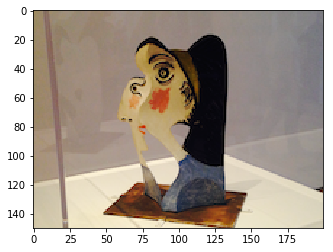

In [7]:
# let's see the image
imgplot = plt.imshow(img)

#### Looking at the histogram for intensity

#### Visualizing the channels

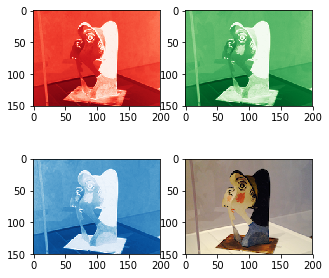

In [9]:
R_img = img[:,:,0]
G_img = img[:,:,1]
B_img = img[:,:,2]
plt.subplot(221)
plt.imshow(R_img, cmap=plt.cm.Reds)
plt.subplot(222)
plt.imshow(G_img, cmap=plt.cm.Greens)
plt.subplot(223)
plt.imshow(B_img, cmap=plt.cm.Blues)  
plt.subplot(224)
plt.imshow(img) 
plt.show()

More on preprocessing data below!

If you want to learn more: [Image Processing with Python and Scipy](http://prancer.physics.louisville.edu/astrowiki/index.php/Image_processing_with_Python_and_SciPy)

## Part 3: Putting the Parts together to make a small ConvNet Model

Let's put all the parts together to make a convnet for classifying our good old MNIST digits.

In [7]:
# Load data and preprocess
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() # load MNIST data
train_images.shape

(60000, 28, 28)

In [8]:
train_images.max(), train_images.min()

(255, 0)

In [9]:
train_images = train_images.reshape((60000, 28, 28, 1)) # Reshape to get third dimension
train_images = train_images.astype('float32') / 255 # Normalize between 0 and 1

test_images = test_images.reshape((10000, 28, 28, 1)) # Reshape to get third dimension
test_images = test_images.astype('float32') / 255 # Normalize between 0 and 1

# Convert labels to categorical data
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [14]:
mnist_cnn_model = models.Sequential() # Create sequential model

# Add network layers
mnist_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
mnist_cnn_model.add(layers.MaxPooling2D((2, 2)))
mnist_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
mnist_cnn_model.add(layers.MaxPooling2D((2, 2)))
mnist_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely connected classifier network like those you’re already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few Dense layers on top.

In [15]:
mnist_cnn_model.add(layers.Flatten())
mnist_cnn_model.add(layers.Dense(64, activation='relu'))
mnist_cnn_model.add(layers.Dense(10, activation='softmax'))

mnist_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [16]:
# Compile model
mnist_cnn_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
mnist_cnn_model.fit(train_images, train_labels, epochs=5, batch_size=64)

#  Evaluate the model on the test data:
test_loss, test_acc = mnist_cnn_model.evaluate(test_images, test_labels)
test_acc

Epoch 1/5
60000/60000 [==============================] - 20s 334us/step - loss: 0.1675 - acc: 0.9474
Epoch 2/5
60000/60000 [==============================] - 22s 365us/step - loss: 0.0466 - acc: 0.9853
Epoch 3/5
60000/60000 [==============================] - 22s 365us/step - loss: 0.0320 - acc: 0.9899
Epoch 4/5
60000/60000 [==============================] - 22s 372us/step - loss: 0.0239 - acc: 0.9927
Epoch 5/5
10000/10000 [==============================] - 1s 128us/step


0.9903

A densely connected network (MLP) running MNIST usually has a test accuracy of 97.8%, whereas our basic convnet has a test accuracy of 99.03%: we decreased the error rate by 68% (relative) with only 5 epochs. Not bad! But why does this simple convnet work so well, compared to a densely connected model? The answer is above on how convolutional layers work!

### Data Preprocessing : Meet the `ImageDataGenerator` class in `keras` [(docs)](https://keras.io/preprocessing/image/)

The MNIST and other pre-loaded dataset are formatted in a way that is almost ready for feeding into the model. What about plain images? They should be formatted into appropriately preprocessed floating-point tensors before being fed into the network.

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream. The data has been downloaded for you from https://www.kaggle.com/c/dogs-vs-cats/data The pictures are medium-resolution color JPEGs. 

In [5]:
# TODO: set your base dir to your correct local location
base_dir = 'data/cats_and_dogs_small'

import os, shutil

# Set up directory information

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir))) 
print('total training dog images:', len(os.listdir(train_dogs_dir))) 
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir))) 
print('total test dog images:', len(os.listdir(test_dogs_dir))) 

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


So you do indeed have 2,000 training images, 1,000 validation images, and 1,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

#### Building the network

In [18]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

For the compilation step, you’ll go with the RMSprop optimizer. Because you ended the network with a single sigmoid unit, you’ll use binary crossentropy as the loss.

In [19]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

The steps for getting it into the network are roughly as follows:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically with the class `ImageDataGenerator`, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors. This is what you’ll use here.

In [20]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let’s look at the output of one of these generators: it yields batches of  150×150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point:

In [21]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let’s fit the model to the data using the generator. You do so using the `.fit_generator` method, the equivalent of `.fit` for data generators like this one. It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely, like this one does. 

Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps - the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

When using fit_generator, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation

In [22]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5, # TODO: should be 30
      validation_data=validation_generator,
      validation_steps=50)


# It’s good practice to always save your models after training.
model.save('cats_and_dogs_small_1.h5')

Epoch 1/5
100/100 [==============================] - 54s 537ms/step - loss: 0.6878 - acc: 0.5320 - val_loss: 0.6716 - val_acc: 0.6050
Epoch 2/5
100/100 [==============================] - 54s 542ms/step - loss: 0.6560 - acc: 0.6160 - val_loss: 0.6368 - val_acc: 0.6300
Epoch 3/5
100/100 [==============================] - 53s 531ms/step - loss: 0.6076 - acc: 0.6765 - val_loss: 0.6061 - val_acc: 0.6700
Epoch 4/5
100/100 [==============================] - 54s 535ms/step - loss: 0.5611 - acc: 0.7120 - val_loss: 0.6877 - val_acc: 0.6320
Epoch 5/5
100/100 [==============================] - 54s 537ms/step - loss: 0.5347 - acc: 0.7355 - val_loss: 0.5732 - val_acc: 0.7030


Let’s plot the loss and accuracy of the model over the training and validation data during training:

NameError: name 'history' is not defined

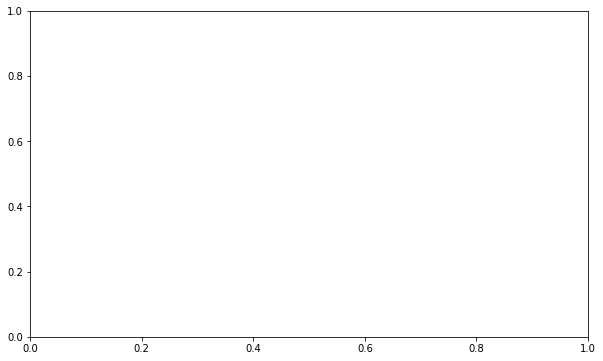

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot((history.history['acc']), 'r', label='train')
ax.plot((history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

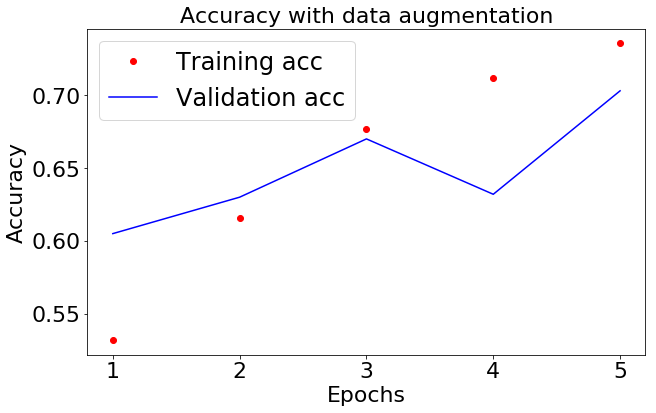

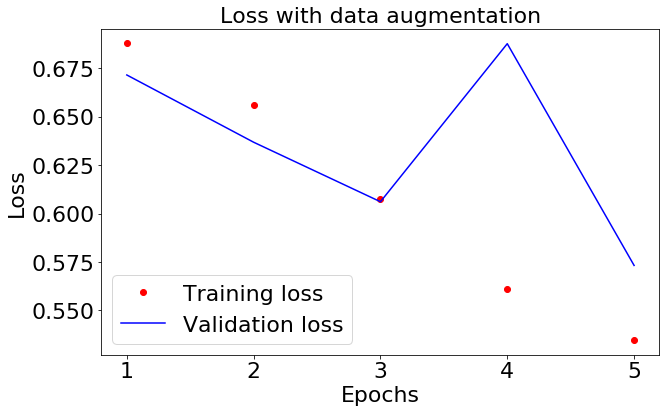

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(epochs, acc, 'ro', label='Training acc')
ax.plot(epochs, val_acc, 'b', label='Validation acc')
ax.set_title('Accuracy without data augmentation', fontsize=22)
ax.set_xlabel(r'Epochs', fontsize=22)
ax.set_ylabel(r'Accuracy', fontsize=22)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)

figL, axL = plt.subplots(1,1, figsize=(10,6))

axL.plot(epochs, loss, 'ro', label='Training loss')
axL.plot(epochs, val_loss, 'b', label='Validation loss')
axL.set_title('Loss without data augmentation', fontsize=22)
axL.set_xlabel(r'Epochs', fontsize=22)
axL.set_ylabel(r'Loss', fontsize=22)
axL.tick_params(labelsize=22)
axL.legend(fontsize=22)

Let's try data augmentation

In [24]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). 
Let’s quickly go over this code:

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half the images horizontally—relevant when there are no assumptions of - horizontal asymmetry (for example, real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift. 

Let’s look at the augmented images

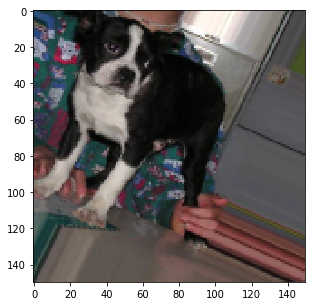

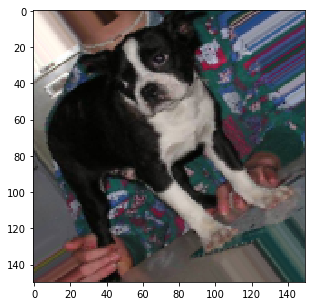

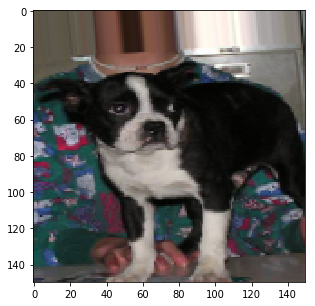

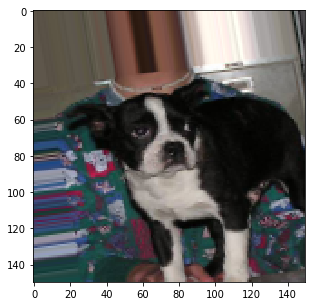

In [26]:
from keras.preprocessing import image
fnames = [os.path.join(train_dogs_dir, fname) for
     fname in os.listdir(train_dogs_dir)]
img_path = fnames[3] # Chooses one image to augment
img = image.load_img(img_path, target_size=(150, 150))
# Reads the image and resizes it
x = image.img_to_array(img) # Converts it to a Numpy array with shape (150, 150, 3) 
x = x.reshape((1,) + x.shape) # Reshapes it to (1, 150, 150, 3)
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a **Dropout** layer to your model right before the densely connected classifier.

In [27]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [28]:
# Let’s train the network using data augmentation and dropout.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)
# Note that the validation data shouldn’t be augmented!

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5, # TODO: should be 100
      validation_data=validation_generator,
      validation_steps=50)

model.save('cats_and_dogs_small_2.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 83s 834ms/step - loss: 0.6935 - acc: 0.5103 - val_loss: 0.6835 - val_acc: 0.5971
Epoch 2/5
100/100 [==============================] - 85s 847ms/step - loss: 0.6825 - acc: 0.5588 - val_loss: 0.7148 - val_acc: 0.5226
Epoch 3/5
100/100 [==============================] - 85s 849ms/step - loss: 0.6766 - acc: 0.5794 - val_loss: 0.6493 - val_acc: 0.6155
Epoch 4/5
100/100 [==============================] - 85s 845ms/step - loss: 0.6558 - acc: 0.5991 - val_loss: 0.6216 - val_acc: 0.6276
Epoch 5/5
100/100 [==============================] - 85s 854ms/step - loss: 0.6436 - acc: 0.6312 - val_loss: 0.6066 - val_acc: 0.6580


And let’s plot the results again. Thanks to data augmentation and dropout, you’re no longer overfitting: the training curves are closely tracking the validation curves. You now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model. (Note: these numbers are for 100 epochs..)

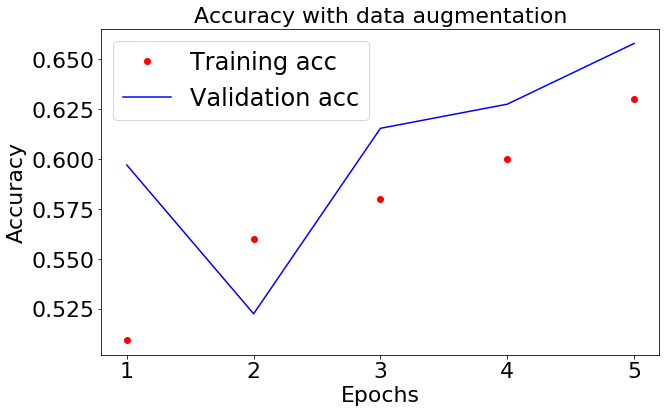

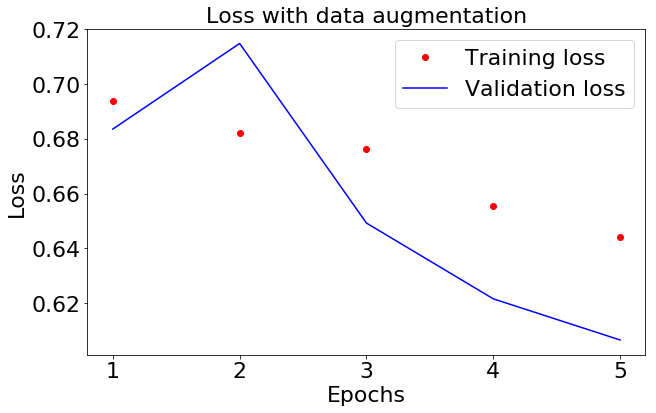

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(epochs, acc, 'ro', label='Training acc')
ax.plot(epochs, val_acc, 'b', label='Validation acc')
ax.set_title('Accuracy with data augmentation', fontsize=22)
ax.set_xlabel(r'Epochs', fontsize=22)
ax.set_ylabel(r'Accuracy', fontsize=22)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)

figL, axL = plt.subplots(1,1, figsize=(10,6))

axL.plot(epochs, loss, 'ro', label='Training loss')
axL.plot(epochs, val_loss, 'b', label='Validation loss')
axL.set_title('Loss with data augmentation', fontsize=22)
axL.set_xlabel(r'Epochs', fontsize=22)
axL.set_ylabel(r'Loss', fontsize=22)
axL.tick_params(labelsize=22)
axL.legend(fontsize=22)

By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per convolution layer, or the number of layers in the network), you may be able to get an even better accuracy, likely up to 86% or 87%. But it would prove difficult to go any higher just by training your own convnet from scratch, because you have so little data to work with. As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model.

## Part 4: keras viz toolkit

https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb

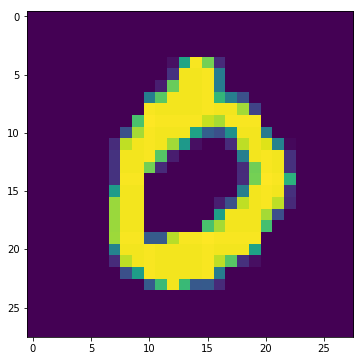

In [10]:
class_idx = 0
indices = np.where(test_labels[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(test_images[idx][..., 0])

In [11]:
input_shape=(28, 28, 1)
num_classes = 10
batch_size = 128
epochs = 5

model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_images, test_labels))

score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 81s 1ms/step - loss: 0.2462 - acc: 0.9248 - val_loss: 0.0524 - val_acc: 0.9828
Epoch 2/5
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0905 - acc: 0.9726 - val_loss: 0.0391 - val_acc: 0.9857
Epoch 3/5
60000/60000 [==============================] - 83s 1ms/step - loss: 0.0691 - acc: 0.9788 - val_loss: 0.0376 - val_acc: 0.9876
Epoch 4/5
60000/60000 [==============================] - 81s 1ms/step - loss: 0.0544 - acc: 0.9832 - val_loss: 0.0307 - val_acc: 0.9896
Epoch 5/5
60000/60000 [==============================] - 84s 1ms/step - loss: 0.0467 - acc: 0.9854 - val_loss: 0.0305 - val_acc: 0.9904
Test loss: 0.030515316201592212
Test accuracy: 0.9904


In [12]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

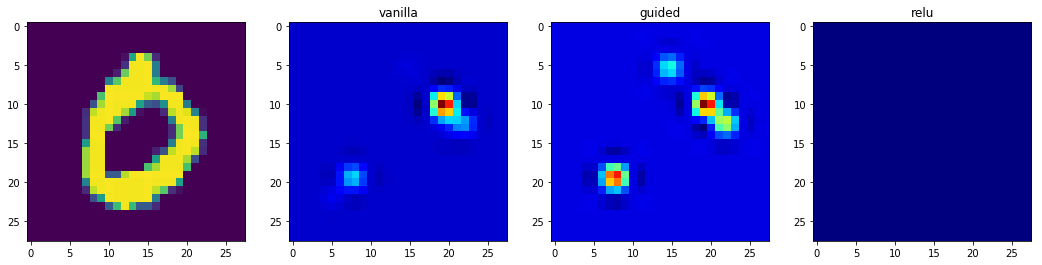

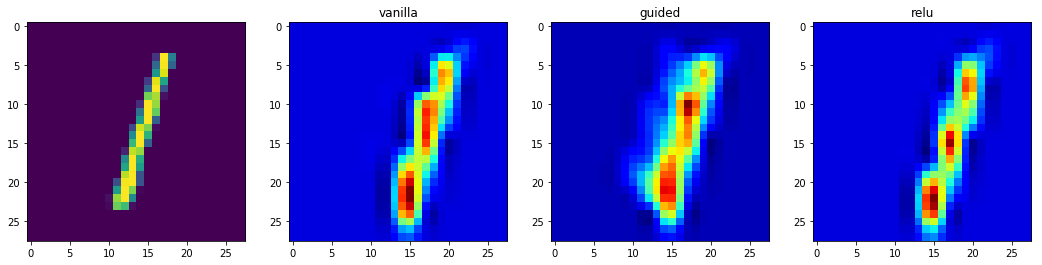

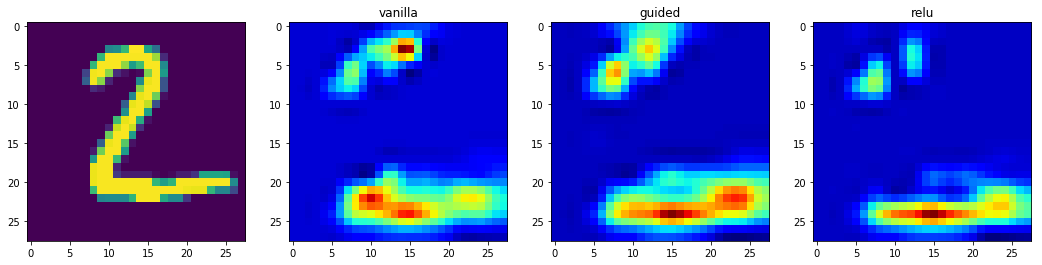

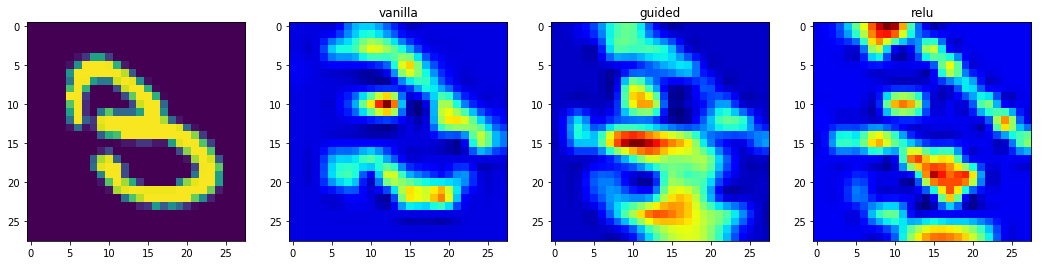

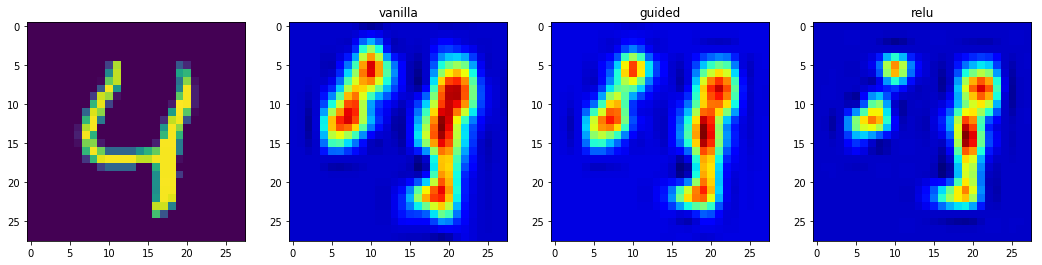

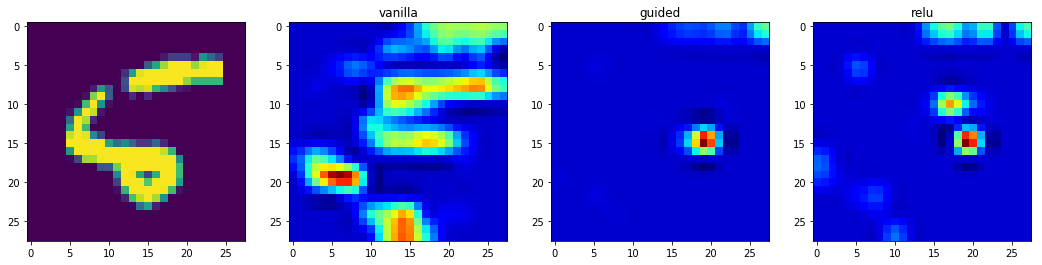

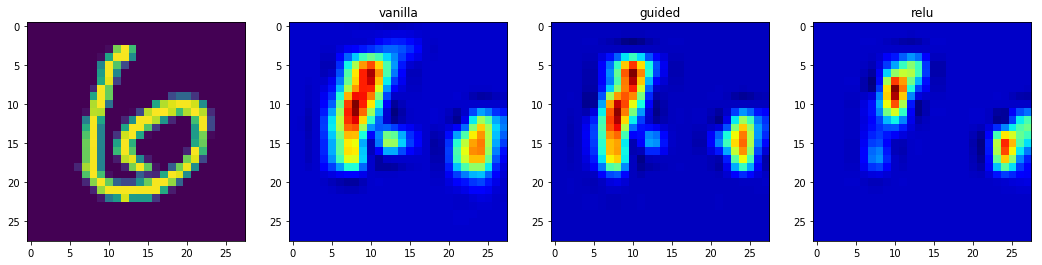

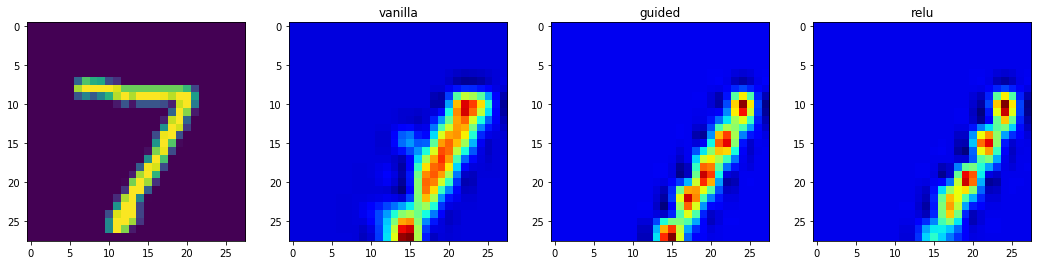

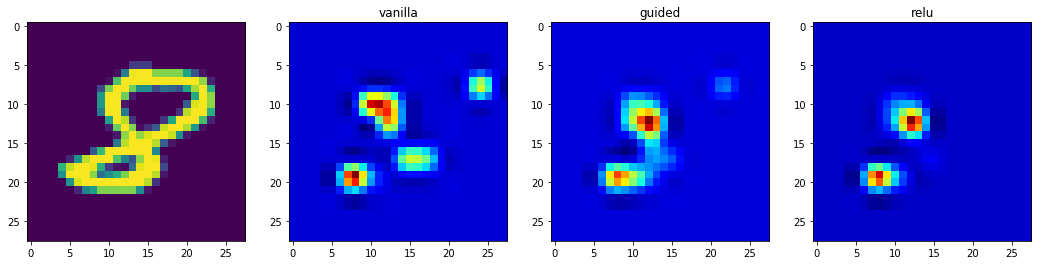

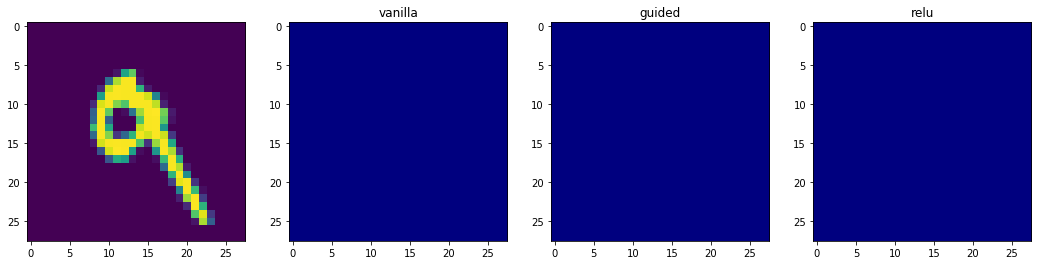

In [13]:
plt.rcParams["figure.figsize"] = (5,5)
from vis.visualization import visualize_cam
import warnings
warnings.filterwarnings('ignore')

# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(test_labels[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(test_images[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=test_images[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

#### References and Acknowledgements
The cats and dogs part of this lab is based on the book Deep Learning with Python, Chapter 5 written by the Francois Chollet, the author of Keras. It is a very practical introduction to Deep Learning. It is appropriate for those with some Python knowledge who want to start with machine learning.

The saliency maps are from https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb